### Load the data

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import datetime
import matplotlib.pyplot as plt

from helpers import *
from implementations import *
from training_procedure import *

%load_ext autoreload
%autoreload 2

In [2]:
def replaceFirstFeature(tx):
    correct = tx[tx[:,0]!=-999][:,1:]
    ncorrect = tx[tx[:,0]==-999][:, 1:]
    xxN = build_poly(ncorrect, 2)
    
    xx = build_poly(correct, 2)
    
    xx_mean = np.mean(xx, axis=0)
    xx_std = np.std(xx, axis=0)
    xx = (xx - xx_mean) / xx_std
    
    w_init = np.zeros(xx.shape[1])
    w, bestw, losses = train_first_feature(xx[:, 0], xx, w_init, 0.0001, 20, 0)
    newFirst = xxN.dot(bestw)
    print(tx.shape)
    print(newFirst.shape)
    print(ncorrect.shape)
    print(np.insert(ncorrect, 0, newFirst, axis=1).shape)

In [3]:
y, tx, ids = load_csv_data("train.csv", sub_sample=False)

# change outlier values to the mean without them
mean = []
for i in range(tx.shape[1]):
    tx[:, i][tx[:, i] == -999] = np.mean(tx[:, i][tx[:, i] != -999])
    mean.append(np.mean(tx[:, i][tx[:, i] != -999]))
# transform the categorical features into one-hot features
#tx_ = np.delete(tx, 22, axis = 1)
#tx = np.hstack((tx,tx_**2,tx_**3,np.sin(tx_),np.cos(tx_),np.sin(2*tx_),np.cos(2*tx_),np.sin(tx_)**2,np.cos(tx_)**2,np.sin(0.5*tx_),np.cos(0.5*tx_),
#    (tx[:, 22] == 0).astype(np.float64)[:, np.newaxis],
#    (tx[:, 22] == 1).astype(np.float64)[:, np.newaxis],
#    (tx[:, 22] == 2).astype(np.float64)[:, np.newaxis],
#    (tx[:, 22] == 3).astype(np.float64)[:, np.newaxis]))
ind = np.where(tx[:, 22] > 1)
tx_ = np.delete(tx[tx[:, 22] > 1], 22, axis = 1)
tx__ = np.hstack([tx[tx[:, 22] > 1],tx_[:,0].reshape((tx_.shape[0],1))*tx_,tx_[:,1].reshape((tx_.shape[0],1))*tx_,tx_[:,2].reshape((tx_.shape[0],1))*tx_,tx_[:,3].reshape((tx_.shape[0],1))*tx_,tx_[:,4].reshape((tx_.shape[0],1))*tx_,tx_[:,5].reshape((tx_.shape[0],1))*tx_,tx_[:,6].reshape((tx_.shape[0],1))*tx_,
                tx_[:,7].reshape((tx_.shape[0],1))*tx_,np.sin(tx_),tx_[:,8].reshape((tx_.shape[0],1))*tx_,
                tx_[:,9].reshape((tx_.shape[0],1))*tx_,tx_[:,10].reshape((tx_.shape[0],1))*tx_,
                tx_[:,11].reshape((tx_.shape[0],1))*tx_,tx_[:,12].reshape((tx_.shape[0],1))*tx_,tx_[:,13].reshape((tx_.shape[0],1))*tx_,
                tx_[:,14].reshape((tx_.shape[0],1))*tx_,tx_[:,15].reshape((tx_.shape[0],1))*tx_,tx_[:,16].reshape((tx_.shape[0],1))*tx_,
                tx_[:,17].reshape((tx_.shape[0],1))*tx_,tx_[:,18].reshape((tx_.shape[0],1))*tx_,tx_[:,19].reshape((tx_.shape[0],1))*tx_,
                np.cos(tx_),np.sin(2*tx_),np.cos(2*tx_)])
tx = np.hstack([tx_])
tx = np.delete(tx, 22, axis = 1)

# standardization
tx_mean = np.mean(tx[:, 1:], axis=0)
tx_std = np.std(tx[:, 1:], axis=0)
tx[:, 1:] = (tx[:, 1:] - tx_mean) / tx_std




In [4]:
def correctOutliers(xi, lower, upper, newVals):
    a = xi > upper
    b = xi < lower
    aorb = np.logical_or(a,b)
    xxi = np.where(aorb, newVals, xi)
    return xxi

def handleOutliers(tx):
    q3, q2, q1 = np.quantile(tx, [0.75, 0.5, 0.25], axis=0)
    iqr = q3 - q1
    upper = q3 + 1.5*iqr
    lower = q1 - 1.5*iqr
    print(np.argwhere(tx > upper).shape)
    print(np.argwhere(tx < lower).shape)
    #t2 = tx > upper
    #tx_outliers = np.logical_or(tx > upper, tx < lower)
    tx2 = np.apply_along_axis(correctOutliers, axis=1, arr=tx, lower=lower, upper=upper, newVals=q2)
    return tx2

In [5]:
print(tx.shape)

(72543, 28)


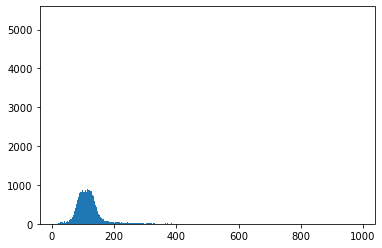

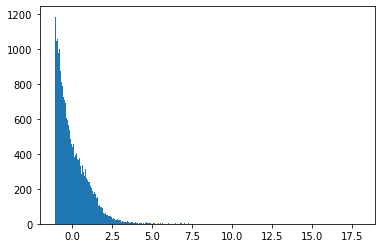

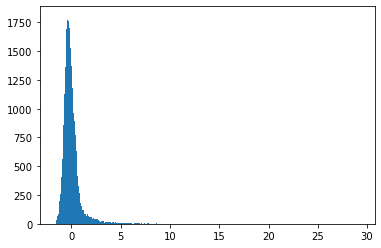

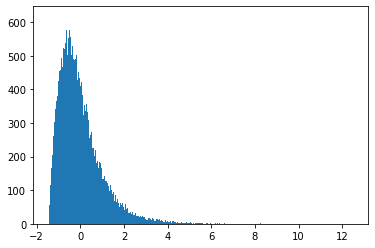

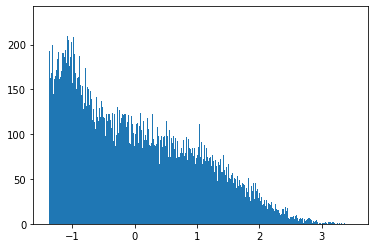

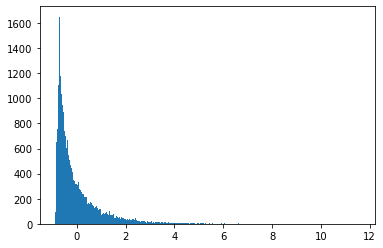

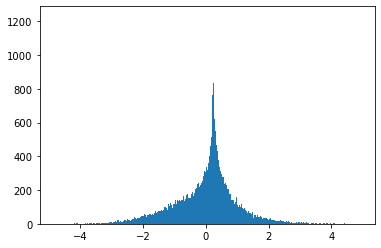

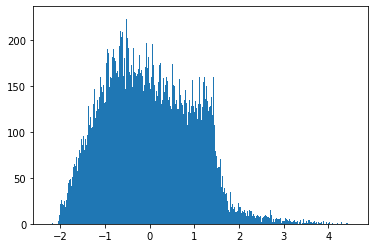

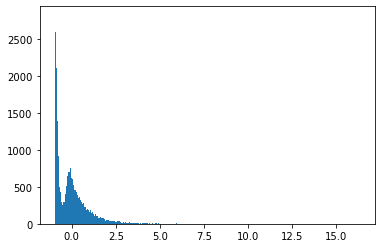

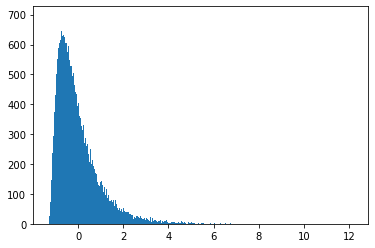

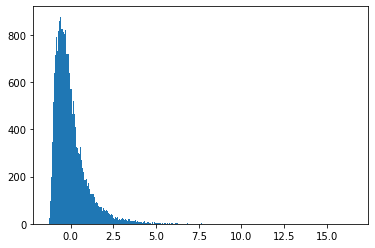

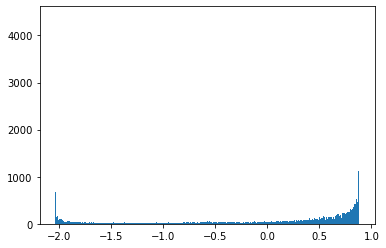

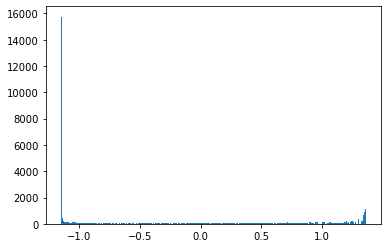

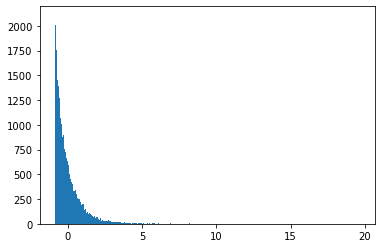

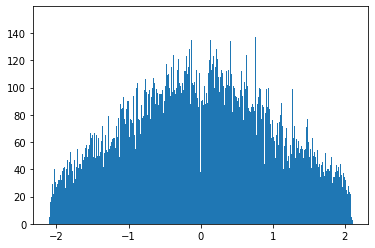

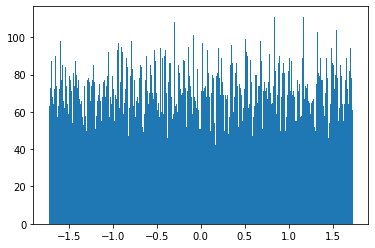

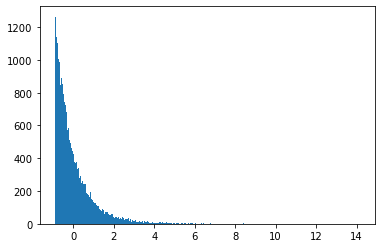

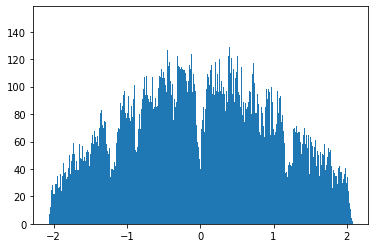

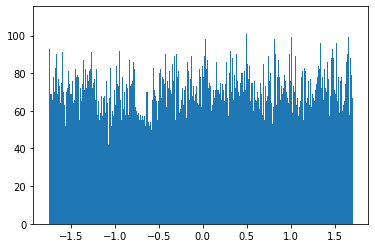

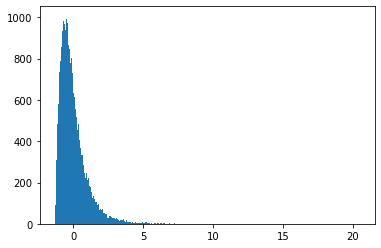

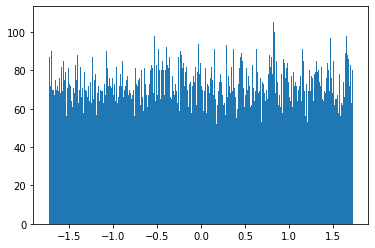

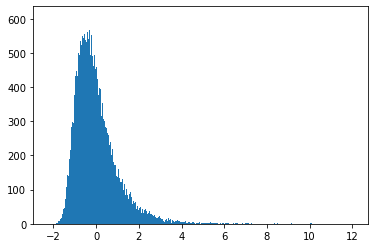

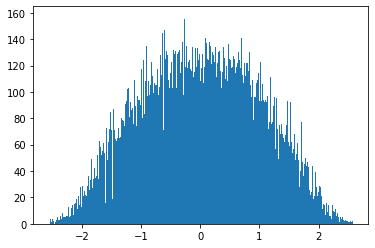

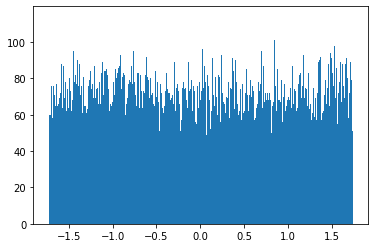

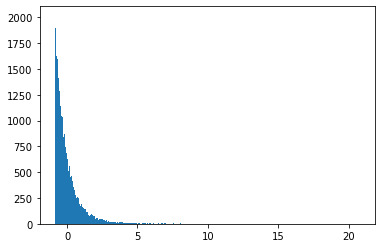

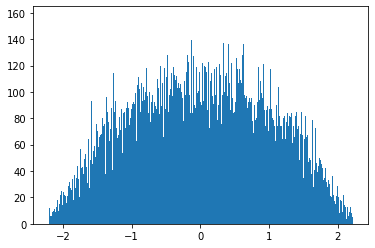

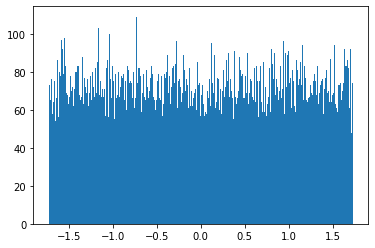

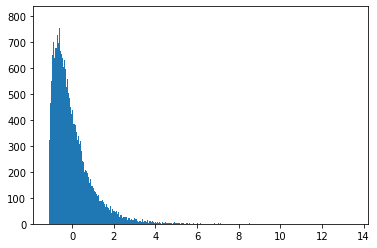

In [12]:
nb = 1000
for i in range(tx.shape[1]):
    n, bins, patches = plt.hist(tx[:, i], nb)
    plt.show()

In [ ]:
tx = handleOutliers(tx)

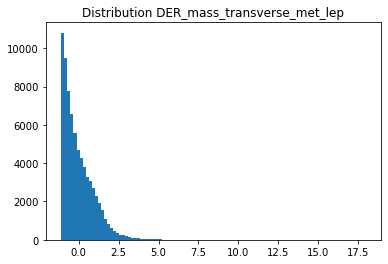

In [11]:
n, bins, patches = plt.hist(tx[:, 1], nb)
plt.title('Distribution DER_mass_transverse_met_lep')
plt.show()

In [ ]:
# standardization
tx_mean = np.mean(tx, axis=0)
tx_std = np.std(tx, axis=0)
tx = (tx - tx_mean) / tx_std

### Gradient Descent

In [ ]:
# Define the parameters of the algorithm.
max_iters = 10
gamma = 0.01

# Initialization
initial_w = np.zeros(tx.shape[1])

# Start gradient descent.
start_time = datetime.datetime.now()
gd_ws, gd_losses= least_squares_GD(y[ind], tx, initial_w, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time = {t:.3f} seconds".format(t=exection_time))
print("Gradient Descent: loss = {t}".format(t=gd_losses))

In [ ]:
y_pred = tx @ gd_ws
y_pred[y_pred > 0] = 1
y_pred[y_pred < 0] = -1
print('Gradient descent accuracy:', np.mean(y_pred == y[ind]))

### Stochastic Gradient Descent

In [ ]:
# Define the parameters of the algorithm.
max_iters = 10
gamma = 0.0005
sgd_ws = np.zeros(tx.shape[1])

# Initialization
initial_w = sgd_ws

# Start gradient descent.
start_time = datetime.datetime.now()
sgd_ws, sgd_losses= least_squares_SGD(y[ind], tx, initial_w, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Stochastic Gradient Descent: execution time = {t:.3f} seconds".format(t=exection_time))
print("Stochastic Gradient Descent: loss = {t}".format(t=sgd_losses))

In [ ]:
y_pred = tx @ sgd_ws
y_pred[y_pred > 0] = 1
y_pred[y_pred < 0] = -1
print('Stochastic gradient descent accuracy:', np.mean(y_pred == y[ind]))

### Least Squares

In [ ]:
# Start least squares.
start_time = datetime.datetime.now()
ls_ws, ls_losses= least_squares(y[ind], tx)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Least Squares: execution time = {t:.3f} seconds".format(t=exection_time))
print("Least Squares: loss = {t}".format(t=ls_losses))

In [ ]:
y_pred = tx @ ls_ws
y_pred[y_pred > 0] = 1
y_pred[y_pred < 0] = -1
print('Least squares accuracy:', np.mean(y_pred == y[ind]))

### Ridge Regression

In [ ]:
# initialization
degree = 1
ratio = 0.8
seed = None
lambdas = np.logspace(-20, -15, 150)

# select lambda
lambda_ = hyperparameter_tuning_ridge_regression(tx, y[ind], degree, ratio, seed, lambdas)

# Start ridge regression
start_time = datetime.datetime.now()
r_ws, r_losses = ridge_regression(y[ind], tx, lambda_)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Ridge Regression: execution time = {t:.3f} seconds".format(t=exection_time))
print("Hyperparameter Selection: Lambda = {t}".format(t=lambda_))
print("Ridge Regression: loss = {t}".format(t=r_losses))

In [ ]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold.
    return dimension: k-fold * interval
    """
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)] 
    return np.array(k_indices)

In [ ]:
# Cross Validation

# Initialization
seed = None
k_fold = 5
k_indices = build_k_indices(y[ind], k_fold, seed)

train_acc = []
val_acc = []
for k in range(k_fold):
    val_y = y[k_indices[k, :]]
    val_x = tx[k_indices[k, :]]
    train_idx = np.vstack([k_indices[:k, :], k_indices[k+1:, :]]).flatten()
    train_y = y[train_idx]
    train_x = tx[train_idx]

    print('------', k, 'fold ------')
    w, loss = ridge_regression(train_y, train_x, lambda_)
    pred = train_x @ w
    pred[pred > 0] = 1
    pred[pred < 0] = -1
    train_acc.append(np.mean(pred == train_y))
    print('Train acc:', np.mean(pred == train_y))
    pred = val_x @ w
    pred[pred > 0] = 1
    pred[pred < 0] = -1
    val_acc.append(np.mean(pred == val_y))
    print('Validation acc:', np.mean(pred == val_y))

print('------ summary ------')
print('Average Train acc:', sum(train_acc)/len(train_acc))
print('Average Validation acc:', sum(val_acc)/len(val_acc))

## Logistic Regression

In [ ]:
# Define the parameters of the algorithm.
max_iters = 2
gamma = 0.0005


# Initialization
initial_w = np.zeros((tx.shape[1]))

# Start gradient descent.
start_time = datetime.datetime.now()
gd_ws, gd_losses= logistic_regression(y[ind], tx, initial_w, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time = {t:.3f} seconds".format(t=exection_time))
print("Gradient Descent: loss = {t}".format(t=gd_losses))

In [ ]:
def predict_labels_logit(w, tx):
    y_pred = sigmoid(np.dot(tx, w))
    y_pred[np.where(y_pred <= 0.5)] = -1
    y_pred[np.where(y_pred > 0.5)] = 1
    return y_pred
# predictions
y_pred = predict_labels_logit(gd_ws, tx)

# accuracy
(y_pred == y[ind]).mean()

## Regularized logistic regression

In [ ]:
# Define the parameters of the algorithm.
max_iters = 3
gamma = 0.0001
lambda_ = 0.00001

# Initialization
initial_w = np.zeros((tx.shape[1]))

# Start gradient descent.
start_time = datetime.datetime.now()
gd_ws, gd_losses= reg_logistic_regression(y[ind], tx,lambda_, initial_w, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time = {t:.3f} seconds".format(t=exection_time))
print("Gradient Descent: loss = {t}".format(t=gd_losses))

In [ ]:
# predictions
y_pred = predict_labels_logit(gd_ws, tx)

# accuracy
(y_pred == y[ind]).mean()

In [ ]:
#reg_logit_loss(y,tx,lambda_,gd_ws)
#(sigmoid(tx@gd_ws)<0).sum()
#tx@gd_ws

In [ ]:

#xx = build_poly(tx[:, 1:], 2)[:, 1:]
xx = tx[tx[:,0]!=-999][:,1:]
yy = tx[tx[:,0]!=-999][:,0]
print(xx.shape)
print(yy.shape)
print(tx[:, 0].shape)
print(tx[:, 1:].shape)
w_init = np.zeros(xx.shape[1])
train_first_feature(yy, xx, w_init, 0.0001, 20, 0)